# Modelo para detección de señales de tránsito

### Entrenamiento
Vamos a usar YOLOv8n pues es el modelo pre entrenado mas rapido de YOLOv8 y es el mas apto para las aplicaciones en tiempo real donde el dispositivo probablemente sea de baja potencia. Cabe mencionar que para esta parte hemos movido el set de datos a la carpeta raiz del proyecto de YOLO para poder hacer el entrenamiento.

In [1]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import numpy as np
import json
import glob

En caso de ya tener el modelo entrenado entonces no es necesario hacer el entrenamiento y se puede comentar el fragmento de código para ahorrar el tiempo de ejecución que toma entrenar.

In [2]:
from ultralytics import YOLO

# model = YOLO('yolov8n.pt')

# # Entrenar el modelo
# model.train(
#     data='dataset.yaml',
#     imgsz=416,  # Tamaño de imagen mejorado
#     epochs=10,  # Más épocas para un mejor aprendizaje
#     batch=8,   # Lote ajustado según la capacidad del hardware
#     name='yolov8_traffic_sign_model_improved',
#     lr0=0.001,  # Tasa de aprendizaje inicial ajustada
#     patience=10,  # Paciencia en la detención temprana
#     device='cpu'
# )


# Cargar el modelo entrenado usando el archivo de pesos guardado
model = YOLO('traffic_signs_model_optimized.pt')  # Ruta a los pesos del modelo entrenado



Podemos guardar el modelo que vayamos a entrenar y es posible modificar el path para guardarlo en donde nosotros querramos mantenerlo o en dado caso subirlo a algun repositorio virtual.

In [3]:
# model_path = 'traffic_signs_model_optimized.pt'
# model.save(model_path)
# print(f"Modelo optimizado guardado en: {model_path}")

### Evaluación del Modelo

In [4]:
# Evaluar el modelo en el conjunto de prueba
results = model.val(data='dataset.yaml', split='test')

Ultralytics YOLOv8.2.94 🚀 Python-3.10.5 torch-2.4.0 CPU (Apple M1)
Model summary (fused): 168 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /Users/marcojurado/Documents/GitHub/car_buddy/datasets/split_dataset/test/labels.cache... 1750 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1750/1750 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 110/110 [05:18<00:00,  2.90s/it]


                   all       1750       1750     0.0168     0.0428     0.0122    0.00124
pedestrian_traffic_light_green        292        292    0.00121    0.00342    0.00434   0.000514
pedestrian_traffic_light_red        291        291          0          0    0.00115   0.000115
   traffic_light_green        292        292          0          0    4.9e-05    4.9e-06
     traffic_light_red        292        292          0          0          0          0
  traffic_light_yellow        291        291          0          0          0          0
                  stop        292        292     0.0998      0.253     0.0679    0.00681
Speed: 0.7ms preprocess, 178.7ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val5


### Pruebas de inferencia del modelo

In [5]:
# Realizar predicciones con el modelo entrenado
predictions = model.predict(source='split_dataset/test/images', save=True)



WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs

image 1/1750 /Users/marcojurado/Documents/GitHub/car_buddy/Traffic_Signs_Model/split_dataset/test/images/20170701_105442_jpg_rf_142da3d52cafe57e710cfaa35c19a216_low_brightness.jpg: 640x640 2 traffic_light_greens, 1 traffic_light_red, 88.3ms
image 2/1750 /Users/marcojurado/Documents/GitHub/car_buddy/Traffic_Signs_Model/split_dataset/test/images/20170701_105442_jpg_rf_5184fc4338e9835ed39bae8ed37b8a18_rot_180.jpg: 640x640 2 traffic_light_greens, 83.8ms
im

## Metrcias del modelo

In [6]:
%matplotlib inline

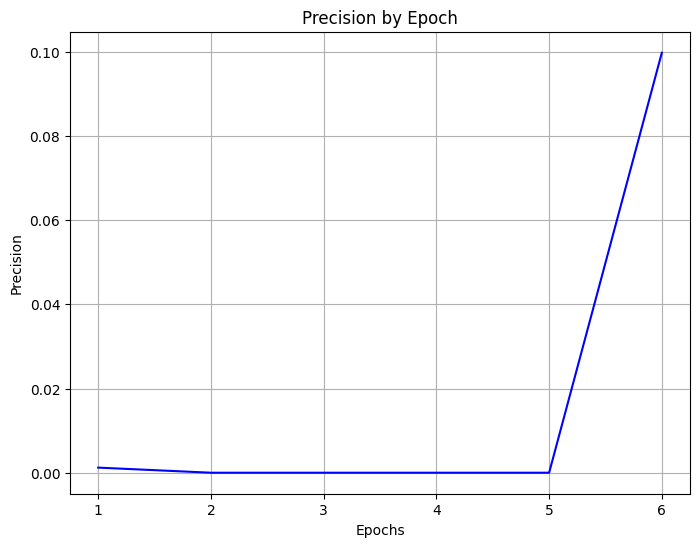

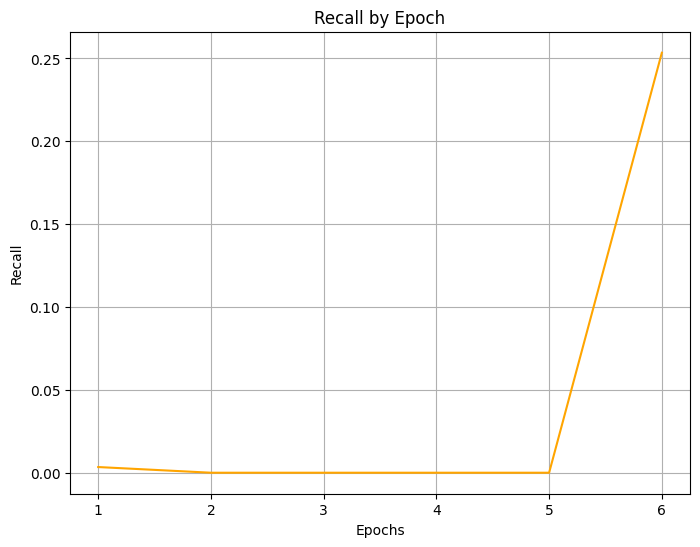

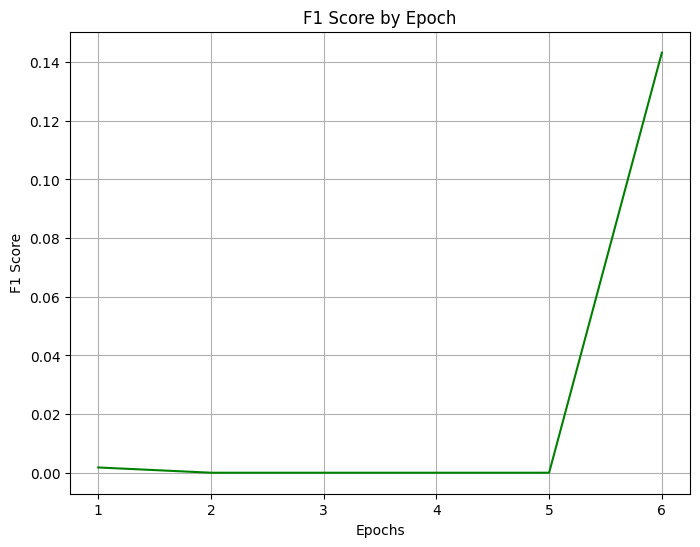

In [7]:
# Supongamos que results contiene los resultados de validación del último epoch
precision = np.array(getattr(results.box, 'p', []))
recall = np.array(getattr(results.box, 'r', []))
mAP_50 = getattr(results.box, 'map', None)
mAP_50_95 = getattr(results.box, 'map95', None)

# Definir epsilon para evitar división por cero
epsilon = 1e-10

# Calcular F1 Score
if precision.size > 0 and recall.size > 0:
    f1 = 2 * (precision * recall) / (precision + recall + epsilon)
else:
    f1 = None

# Calcular Accuracy
accuracy = (mAP_50 + mAP_50_95) / 2 if mAP_50 is not None and mAP_50_95 is not None else None

# Definir las épocas (suponiendo que el número de épocas es igual a la longitud de precision)
epochs = np.arange(1, len(precision) + 1) if precision.size > 0 else []

# Gráfico de Precision
plt.figure(figsize=(8, 6))
plt.plot(epochs, precision, label='Precision', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Precision by Epoch')
plt.grid(True)
plt.show()

# Gráfico de Recall
plt.figure(figsize=(8, 6))
plt.plot(epochs, recall, label='Recall', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Recall by Epoch')
plt.grid(True)
plt.show()

# Gráfico de F1 Score
if f1 is not None:
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, f1, label='F1 Score', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('F1 Score by Epoch')
    plt.grid(True)
    plt.show()

# Gráfico de Accuracy
if accuracy is not None:
    plt.figure(figsize=(8, 6))
    plt.plot(epochs, [accuracy] * len(epochs), label='Accuracy', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy by Epoch')
    plt.grid(True)
    plt.show()


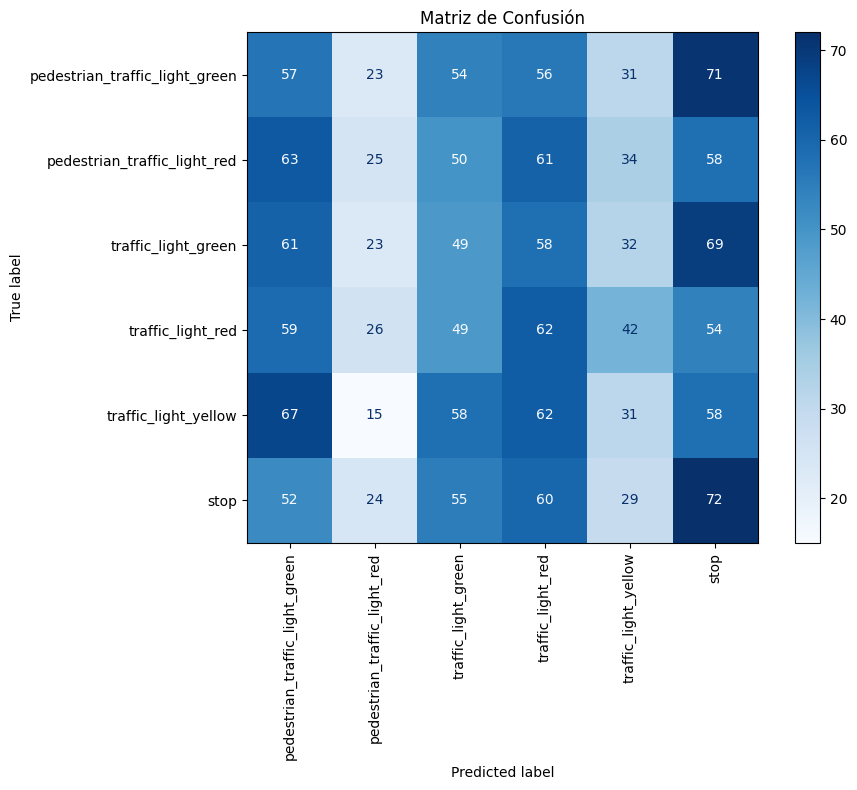

In [8]:
# Obtener nombres de clases
class_names = model.names  # Diccionario que asigna cada índice a su nombre de clase
labels = [class_names[i] for i in range(len(class_names))]  # Lista de nombres de clase en orden

# Inicializar listas para etiquetas verdaderas y predicciones
y_true = []
y_pred = []

# Extraer etiquetas predichas (y_pred) de las predicciones
for prediction in predictions:
    if hasattr(prediction.boxes, 'cls'):
        pred_classes = prediction.boxes.cls.cpu().numpy()  # Convertir a array de numpy
        y_pred.extend(pred_classes)

# Cargar las etiquetas verdaderas (y_true) desde las anotaciones del dataset de prueba
def load_yolo_labels(label_folder):
    y_true = []
    for file in glob.glob(f"{label_folder}/*.txt"):  # Ruta a los archivos de etiquetas en formato YOLO
        with open(file, 'r') as f:
            for line in f:
                class_id = int(line.split()[0])  # Primer valor es el ID de la clase en formato YOLO
                y_true.append(class_id)
    return y_true

# Cargar y_true usando la opción para YOLO
y_true = load_yolo_labels('split_dataset/test/labels')  # Ruta a la carpeta de etiquetas de prueba en formato YOLO

# Ajustar listas para asegurarse de que y_true y y_pred tienen la misma longitud
min_len = min(len(y_true), len(y_pred))
y_true = y_true[:min_len]
y_pred = y_pred[:min_len]

if y_true and y_pred:
    # Generar y mostrar la matriz de confusión con etiquetas de clase
    conf_matrix = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(10, 8))  # Ajustar el tamaño de la figura
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)  # Usar nombres de clase en los ejes
    disp.plot(cmap='Blues', ax=ax, xticks_rotation='vertical')
    plt.title("Matriz de Confusión")

    plt.tight_layout()  # Asegura que todo se ajuste bien en la figura
    plt.show()
else:
    print("Unable to extract true and predicted labels. Please verify label extraction or ground truth loading.")